<a href="https://colab.research.google.com/github/jx-dohwan/Deep_Learning_from_Scratch_2_study/blob/main/CH8_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH8_Attention
> 앞 장에서 RNN을 사용해 문장을 생성해봤다. 그리고 2개의 RNN을 연결하여 하나의 시계열 데이터를 다른 시계열 데이터로 변화해 봤다. 우리는 이를 seq2seq라고 한다. <br> 이번 장에서는 seq2seq의 가능성 그리고 RNN의 가능성을 한걸음 더 깊이 탐험할 것이다. 어텐션이다. 어텐션은 최근 딥러닝 분야에서 틀림없이 주용한 기술중 하나이다.

## 1. 어텐션 구조
> 어텐션이라는 메커니즘 덕분에 seq2seq는 필요한 정보에만 주목할 수 있게 된다. 게다가 지금까지의 seq2seq가 안고 있던 문제도 해결할 수 있다. 그래서 가장 먼저 seq2seq의 문제를 살펴보고 어텐션의 구조를 설명 및 구현을 할 예정이다.

### 1) seq2seq의 문제점
> seq2seq에서는 Encoder가 시계열 데이터를 인코딩한다. 그리고 인코딩된 정보를 Decoder로 전달한다. 이때 Encoder의 출력은 '고정 길이의 벡터'였다. 그런데 실은 이 '고정 길이'라는 데에 큰 문제가 잠재해 있다.

- 고정 길이 벡터라 함은 입력 문장의 길이에 관계없이(아무리 길어도), 항상 같은 길이의 벡터로 변환한다는 뜻이다.
- 앞 장의 번역 예로 설명하면 아무리 긴 문장이 입력되더라도 항상 똑같은 길이의 벡터에 밀어 넣어야 한다. 

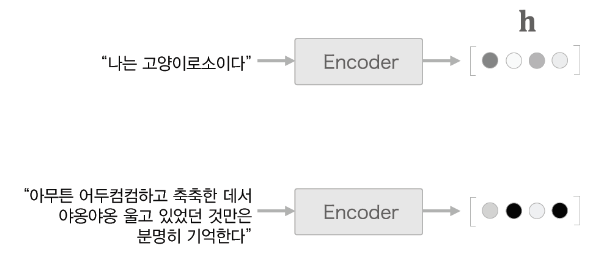

- 현재의 Encoder는 아무리 긴 문장이라도 고정 길이 벡터로 변환한다. 마치 많은 옷가지를 옷장에 욱여넣듯이 억지로 고정 길이의 벡터로 밀어 넣는 것이다.
- 하지만 이렇게 하면 곧 한계가 찾아온다. 결국에는 옷이 옷장에서 빠져나오듯, 필요한 정보가 벡터에 다 담기지 못하게 된다.

### 2) Encoder 개선